In [1]:
import uproot
import numpy as np
#uproot.open("/Users/mliu/Downloads/www_2l_ext1_mia_skim_1_1.root")['h_neventsinfile'].show()
uproot.open("/Users/mliu/Downloads/www_2l_ext1_mia_skim_1_1.root")['t'].keys()

[b'run',
 b'lumi',
 b'evt',
 b'isData',
 b'evt_scale1fb',
 b'evt_passgoodrunlist',
 b'HLT_DoubleMu',
 b'HLT_DoubleEl',
 b'HLT_DoubleEl_DZ',
 b'HLT_DoubleEl_DZ_2',
 b'HLT_MuEG',
 b'HLT_SingleIsoEl8',
 b'HLT_SingleIsoEl17',
 b'HLT_SingleIsoMu8',
 b'HLT_SingleIsoMu17',
 b'mc_HLT_DoubleMu',
 b'mc_HLT_DoubleEl',
 b'mc_HLT_DoubleEl_DZ',
 b'mc_HLT_DoubleEl_DZ_2',
 b'mc_HLT_MuEG',
 b'mc_HLT_SingleIsoEl8',
 b'mc_HLT_SingleIsoEl17',
 b'mc_HLT_SingleIsoMu8',
 b'mc_HLT_SingleIsoMu17',
 b'lep_p4',
 b'lep_pt',
 b'lep_eta',
 b'lep_phi',
 b'lep_coneCorrPt',
 b'lep_ip3d',
 b'lep_ip3derr',
 b'lep_isTriggerSafe_v1',
 b'lep_lostHits',
 b'lep_convVeto',
 b'lep_motherIdSS',
 b'lep_pass_VVV_cutbased_3l_fo',
 b'lep_pass_VVV_cutbased_3l_tight',
 b'lep_pass_VVV_cutbased_fo',
 b'lep_pass_VVV_cutbased_tight',
 b'lep_pass_VVV_cutbased_veto',
 b'lep_pass_VVV_cutbased_fo_noiso',
 b'lep_pass_VVV_cutbased_tight_noiso',
 b'lep_pass_VVV_cutbased_veto_noiso',
 b'lep_pdgId',
 b'lep_dxy',
 b'lep_dz',
 b'lep_ptRatio',
 b'le

In [42]:
#some preselection here
#www is an object of tree type, it has a method of array, which takes the key name and read in one branch as numpyarray
www = uproot.open("/Users/mliu/Downloads/www_2l_ext1_mia_skim_1_1.root")['t']
wz = uproot.open("/Users/mliu/Downloads/totalbkg.root")['t']

www_presel = np.ma.getmask(np.ma.masked_equal(np.logical_or(www.array('passSSee'),www.array('passSSem'),www.array('passSSmm')),1))


features = ['MTmax','MllSS','nTlepSS','met_pt','nVlep','nj30','nb','Mjj','DetajjVBF']
#features = ['MTmax','nTlepSS','met_pt','nVlep','nj30','nb','Mjj','DetajjVBF']

www_features = []
wz_features = []

for var in features:
    www_features.append(np.ma.masked_array(www.array(var),www_presel))
    print(np.ma.masked_array(www.array(var),www_presel))
    wz_features.append(wz.array(var))

sampleweight_www = www.array('evt_scale1fb')*35.9
isSig = np.ones(len(www))
www_features.append(isSig)
www_feature = np.column_stack(www_features)

sampleweight_wz = wz.array('evt_scale1fb')*35.9
isSig_wz = np.zeros(len(wz))
wz_features.append(isSig_wz)
wz_feature = np.column_stack(wz_features)

weight = np.concatenate([sampleweight_www,sampleweight_wz])
sample = np.concatenate([www_feature,wz_feature])
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(sample[:,:-1],sample[:,-1],weight, test_size=0.33, random_state=42)

[-- -- -- ... 127.41976165771484 130.1466522216797 --]
[-- -- -- ... 412.41888427734375 558.5030517578125 --]
[-- -- -- ... 2 2 --]
[-- -- -- ... 136.55372619628906 38.56691360473633 --]
[-- -- -- ... 2 2 --]
[-- -- -- ... 6 1 --]
[-- -- -- ... 1 0 --]
[-- -- -- ... 102.90630340576172 0.0 --]
[-- -- -- ... 0.6356900930404663 -999.0 --]


In [33]:
len(www), len(np.ma.masked_array(www.array(var)))

(6891, 6891)

In [43]:
# feed events into classifier 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                         algorithm="SAMME",learning_rate=0.5,
                         n_estimators=400)

bdt.fit(X_train,y_train,sw_train)
bdt.predict(X_test)

array([0., 0., 0., ..., 0., 0., 0.])

             precision    recall  f1-score   support

 background       0.91      1.00      0.95     22956
     signal       0.67      0.00      0.00      2246

avg / total       0.89      0.91      0.87     25202

Area under ROC curve: 0.8580


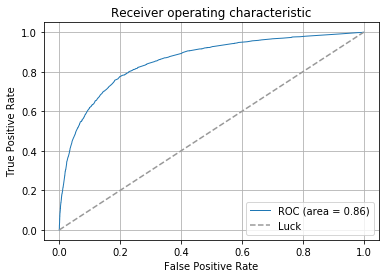

In [44]:
from sklearn.metrics import classification_report, roc_auc_score,roc_curve,auc
y_predicted = bdt.predict(X_test)
print(classification_report(y_test, y_predicted,
                            target_names=["background", "signal"]))
print("Area under ROC curve: %.4f"%(roc_auc_score(y_test,
                                                  bdt.decision_function(X_test))))
decisions = bdt.decision_function(X_test)
# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_test, decisions)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)'%(roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

/Users/mliu/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


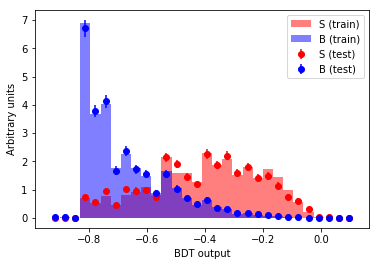

In [45]:
def compare_train_test(clf, X_train, y_train, X_test, y_test, bins=30):
    decisions = []
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.decision_function(X[y>0.5]).ravel()
        d2 = clf.decision_function(X[y<0.5]).ravel()
        decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)
    
    plt.hist(decisions[0],
             color='r', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', normed=True,
             label='S (train)')
    plt.hist(decisions[1],
             color='b', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', normed=True,
             label='B (train)')

    hist, bins = np.histogram(decisions[2],
                              bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')
    
    hist, bins = np.histogram(decisions[3],
                              bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')

    plt.xlabel("BDT output")
    plt.ylabel("Arbitrary units")
    plt.legend(loc='best')
    
compare_train_test(bdt, X_train, y_train, X_test, y_test)

In [141]:
print(twoclass_output[0])

-0.6823879409718133


ModuleNotFoundError: No module named 'torch'